In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import pickle
import requests
from collections import Counter

from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from numpy import log

import pandas_datareader as pdr
from pandas_datareader.tiingo import TiingoDailyReader

from statsmodels.tsa.seasonal import seasonal_decompose


from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
with open('market_cap.pickle','rb') as read_file:
    tech_market_cap = pickle.load(read_file)

In [3]:
with open('stocks_ti.pickle','rb') as read_file:
    tech_stocks_ti = pickle.load(read_file)

In [4]:
tech_market_cap.head(5)

,date,AMZN_cap,MSFT_cap,FB_cap,GOOGL_cap,AAPL_cap
0,2015-01-02,147.16404,339.143194,223.817850,394.51475,563.570212
1,2015-01-05,144.14463,335.988205,220.223070,386.99770,547.693543
2,2015-01-06,140.85333,331.092532,217.255950,377.44680,547.745090
3,2015-01-07,142.34634,335.299184,217.255950,376.33675,555.425687
4,2015-01-08,143.31942,345.163058,223.033275,377.64795,576.766405


In [5]:
tech_market_cap = tech_market_cap.iloc[14:]
tech_market_cap = tech_market_cap.reset_index()
tech_market_cap = tech_market_cap.drop('index',axis=1)
tech_market_cap.head(5)

,date,AMZN_cap,MSFT_cap,FB_cap,GOOGL_cap,AAPL_cap
0,2015-01-23,149.01003,342.189391,222.048990,403.75275,582.385096
1,2015-01-26,147.70782,340.956406,221.093235,399.85640,583.003668
2,2015-01-27,146.31975,309.406515,216.200340,388.28655,562.590807
3,2015-01-28,144.96507,298.744828,217.512720,381.76035,594.395693
4,2015-01-29,148.71906,304.692164,222.534000,382.35635,612.901292


In [6]:
tech_stocks_ti.tail(5)

,FB,AMZN,MSFT,GOOGL,AAPL,FB_volume,AMZN_volume,MSFT_volume,GOOGL_volume,AAPL_volume,...,MSFT_exp_200d,GOOGL_exp_50d,GOOGL_exp_200d,AAPL_exp_50d,AAPL_exp_200d,AMZN_RSI,FB_RSI,MSFT_RSI,GOOGL_RSI,AAPL_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-26,180.36,1768.87,135.45,1171.18,206.49,8780477,3085320,20325271,1058926,26066130,...,122.24,1164.14,1144.47,202.24,191.96,40.220047,40.368986,48.311842,49.290912,51.828460
2019-08-27,181.30,1761.83,135.74,1170.82,204.16,14408946,3027245,23115635,1173489,25897344,...,122.38,1164.40,1144.73,202.31,192.08,39.376503,41.917656,48.911027,49.209286,49.216148
2019-08-28,181.76,1764.25,135.56,1173.75,205.53,9364533,2411125,17343042,833830,15957632,...,122.51,1164.77,1145.02,202.44,192.22,39.843565,42.701882,48.534944,49.935959,50.786827
2019-08-29,185.57,1786.40,138.12,1194.24,209.01,10135033,3018012,20179716,982098,21007652,...,122.66,1165.92,1145.51,202.70,192.38,44.089468,48.860786,53.957317,54.805610,54.625793
2019-08-30,185.67,1776.29,137.86,1190.53,208.74,10785722,3064147,23946123,903375,21162561,...,122.81,1166.89,1145.96,202.93,192.55,42.611132,49.015688,53.342609,53.785484,54.272057


In [7]:
tech_stocks_ti.columns

Index(['FB', 'AMZN', 'MSFT', 'GOOGL', 'AAPL', 'FB_volume', 'AMZN_volume',
       'MSFT_volume', 'GOOGL_volume', 'AAPL_volume', 'AMZN_50d', 'AMZN_200d',
       'FB_50d', 'FB_200d', 'MSFT_50d', 'MSFT_200d', 'GOOGL_50d', 'GOOGL_200d',
       'AAPL_50d', 'AAPL_200d', 'AMZN_exp_50d', 'AMZN_exp_200d', 'FB_exp_50d',
       'FB_exp_200d', 'MSFT_exp_50d', 'MSFT_exp_200d', 'GOOGL_exp_50d',
       'GOOGL_exp_200d', 'AAPL_exp_50d', 'AAPL_exp_200d', 'AMZN_RSI', 'FB_RSI',
       'MSFT_RSI', 'GOOGL_RSI', 'AAPL_RSI'],
      dtype='object')

# ARIMA + SARIMA

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
start = datetime(2019, 9, 1)
end = datetime.now()
    
api_token="0492b847e65cfba1e9abb96cb013c78404d0eb4f"

## Amazon

### ARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


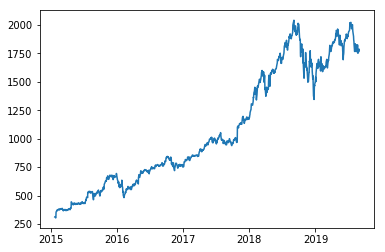

In [12]:
plt.plot(tech_stocks_ti['AMZN'])

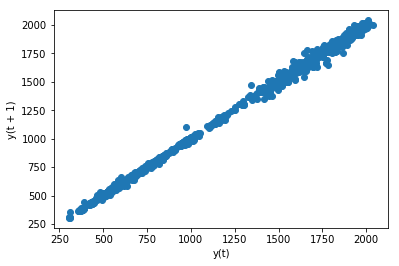

In [13]:
lag_plot(tech_stocks_ti['AMZN'])

In [14]:
result = adfuller(tech_stocks_ti['AMZN'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.707144
p-value: 0.844890


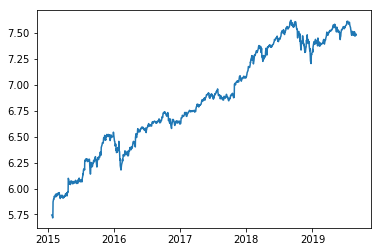

In [15]:
plt.plot(np.log(tech_stocks_ti['AMZN']))

In [16]:
result = adfuller(np.log(tech_stocks_ti['AMZN']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.943493
p-value: 0.311885


In [17]:
result = adfuller(tech_stocks_ti['AMZN'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.932393
p-value: 0.000000


In [18]:
result = adfuller(tech_stocks_ti['AMZN']-tech_stocks_ti['AMZN_exp_200d'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.958370
p-value: 0.038969


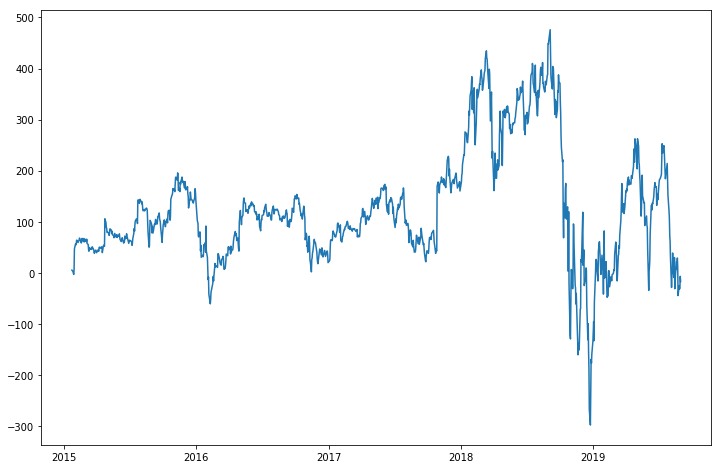

In [19]:
fig = plt.figure(figsize=(12,8))
plt.plot(tech_stocks_ti['AMZN']-tech_stocks_ti['AMZN_exp_200d'])

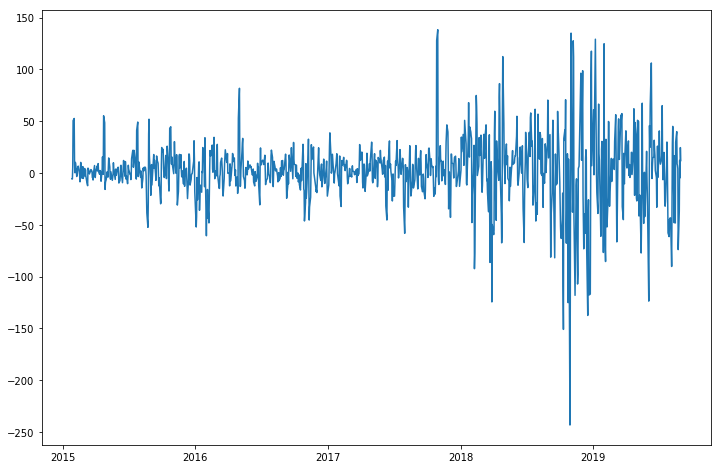

In [20]:
fig = plt.figure(figsize=(12,8))
plt.plot(tech_stocks_ti['AMZN'].diff(periods=2).dropna())

In [21]:
result = adfuller(np.log(tech_stocks_ti['AMZN']).diff(periods=7).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.235243
p-value: 0.000000


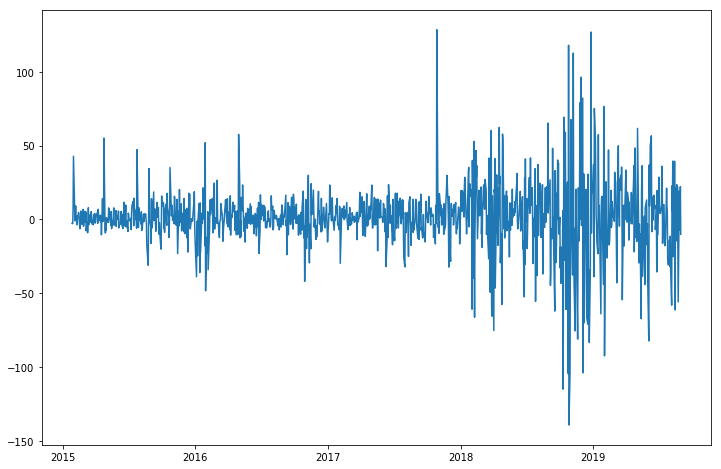

In [22]:
fig = plt.figure(figsize=(12,8))
plt.plot(tech_stocks_ti['AMZN'].diff().dropna())

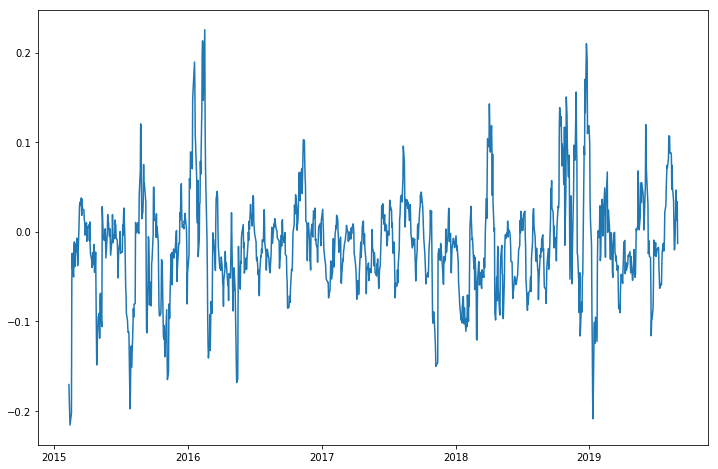

In [23]:
fig = plt.figure(figsize=(12,8))
plt.plot(np.log(tech_stocks_ti['AMZN']).diff().dropna() - np.log(tech_stocks_ti['AMZN']).diff(periods=12).dropna())

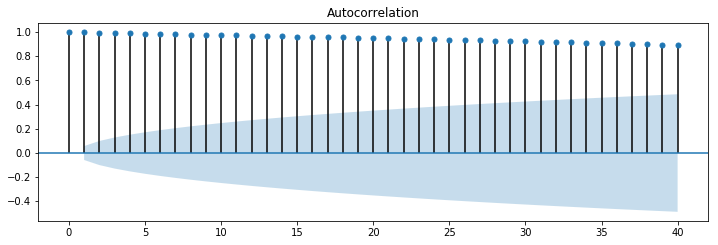

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['AMZN'], lags=40, ax=ax1)
plt.show()

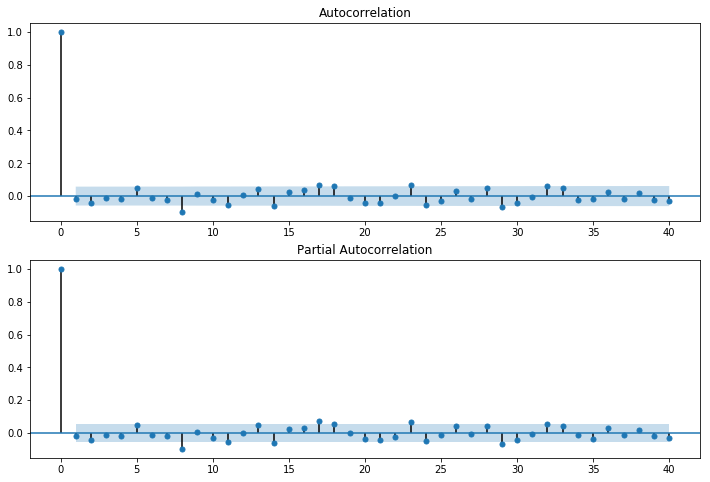

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['AMZN'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tech_stocks_ti['AMZN'].diff().dropna(), lags=40, ax=ax2)
plt.show()

An AR model of 8 and a MA Model of 8 would work here

In [26]:
amzn_train_data, amzn_test_data = tech_stocks_ti['AMZN'][0:int(len(tech_stocks_ti['AMZN'])*0.8)], tech_stocks_ti['AMZN'][int(len(tech_stocks_ti['AMZN'])*0.8):]

Mean Absolute Percentage Error:  26.997084259575637
Root MSE:  482.34090109125606


/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


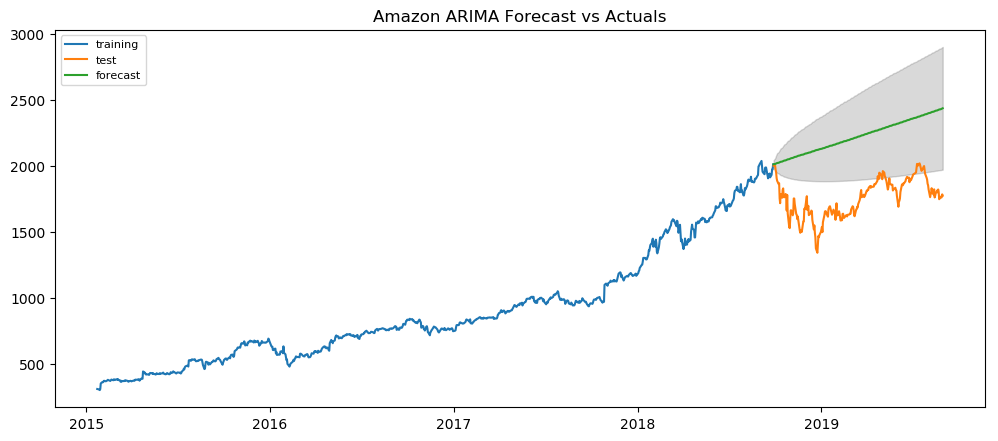

In [27]:
# fit model
model=sm.tsa.ARIMA(endog=amzn_train_data, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(len(amzn_test_data), alpha=0.05)
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc, index=amzn_test_data.index)
#print(fc_series)
lower_series = pd.Series(conf[:, 0], index=amzn_test_data.index)
upper_series = pd.Series(conf[:, 1], index=amzn_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(amzn_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(amzn_test_data, fc_series)))
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(amzn_train_data, label='training')
plt.plot(amzn_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Amazon ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
amzn_model=sm.tsa.ARIMA(endog=tech_stocks_ti['AMZN'],order=(1,1,0))
amzn_results=amzn_model.fit()
print(amzn_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.AMZN   No. Observations:                 1159
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5235.766
Method:                       css-mle   S.D. of innovations             22.166
Date:                Wed, 18 Sep 2019   AIC                          10477.532
Time:                        12:53:10   BIC                          10492.698
Sample:                             1   HQIC                         10483.255
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2633      0.641      1.971      0.049       0.007       2.520
ar.L1.D.AMZN    -0.0157      0.029     -0.534      0.593      -0.073       0.042
                                    Roots   

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


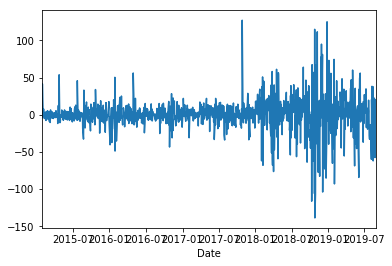

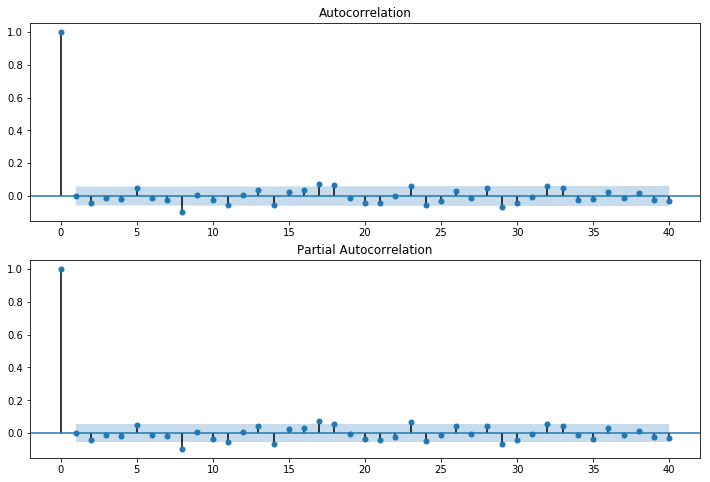

In [29]:
amzn_results.resid.plot()
plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(amzn_results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(amzn_results.resid, lags=40, ax=ax2)
plt.show()

###  Decompositional Trend

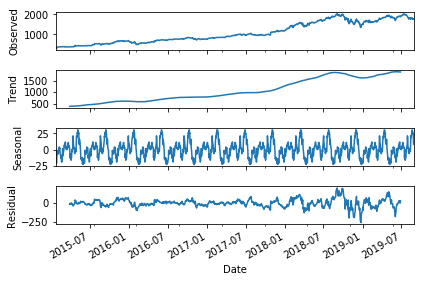

<Figure size 1296x864 with 0 Axes>

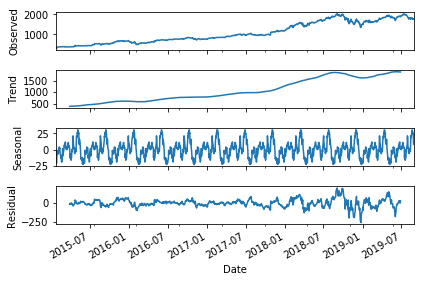

In [41]:
amzn_decompose_df = tech_stocks_ti['AMZN'].reset_index()
amzn_decompose_df['Date'] = pd.to_datetime(amzn_decompose_df['Date'])
amzn_decompose_df = amzn_decompose_df.set_index('Date')
result = seasonal_decompose(amzn_decompose_df, model="additive", freq=90)
fig = plt.figure(figsize=(18,12))
result.plot()

In [42]:
amzn_trend = result.trend.dropna()
amzn_resid = result.resid.dropna()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  4.480766710731355
Root MSE:  92.7825377924163


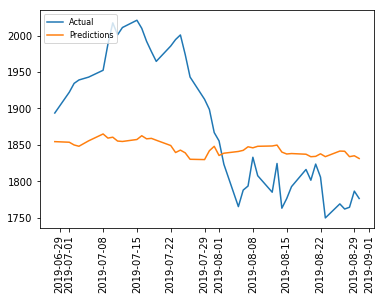

In [43]:
# fit model
model=sm.tsa.ARIMA(endog=amzn_trend, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(45, alpha=0.05)

#print(np.array(fc)+np.array(result.seasonal)[:30])

predictions = fc + result.seasonal.iloc[:45]['AMZN']
predictions = predictions.reset_index()
predictions = predictions.drop('Date', axis=1)

predictions['Date'] = tech_stocks_ti['AMZN'][-45:].index
predictions = predictions.set_index(['Date'])
#predictions
plt.plot(tech_stocks_ti['AMZN'][-45:], label='Actual')
plt.plot(predictions, label='Predictions')
plt.xticks(rotation='vertical')
plt.legend(loc='upper left', fontsize=8)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(tech_stocks_ti['AMZN'][-45:], predictions))
print("Root MSE: ", np.sqrt(mean_squared_error(tech_stocks_ti['AMZN'][-45:], predictions)))

### SARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Absolute Percentage Error:  26.61353427973579
Root MSE:  492.42390650081563


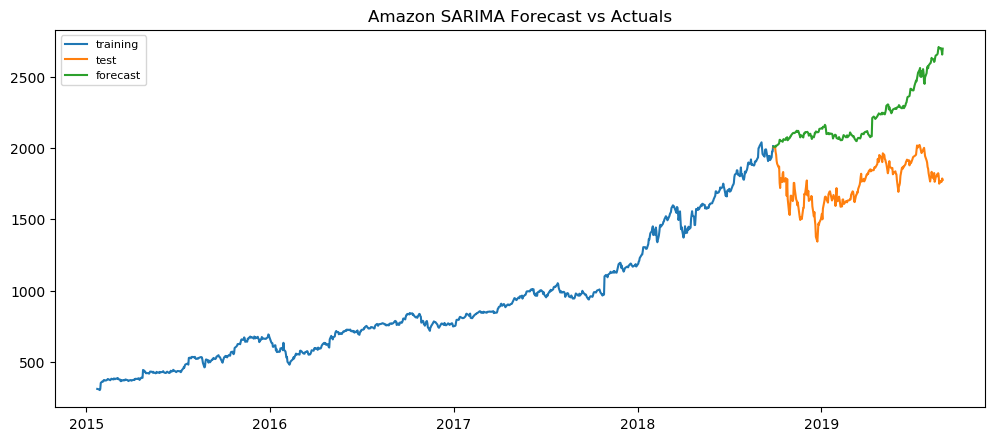

In [35]:
# fit model
model=sm.tsa.statespace.SARIMAX(endog=amzn_train_data, order=(0,1,0), seasonal_order=(0,1,0,365), enforce_stationarity=False, enforce_invertibility=False, alpha=0.05)
model_fit = model.fit(disp=False)
# make prediction


fc = model_fit.forecast(len(amzn_test_data))

#fc = model_fit.get_prediction(len(amzn_test_data), dynamic=False).predicted_mean
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc.values, index=amzn_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(amzn_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(amzn_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(amzn_train_data, label='training')
plt.plot(amzn_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Amazon SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## MSFT

### ARIMA

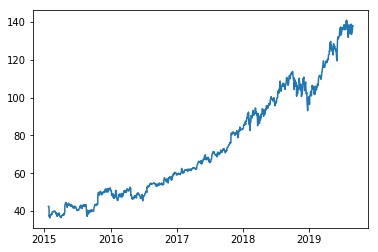

In [44]:
plt.plot(tech_stocks_ti['MSFT'])

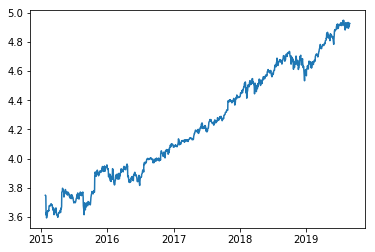

In [45]:
plt.plot(np.log(tech_stocks_ti['MSFT']))

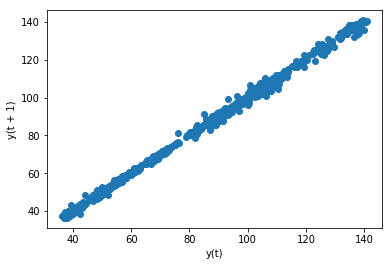

In [46]:
lag_plot(tech_stocks_ti['MSFT'])

In [47]:
result = adfuller(tech_stocks_ti['MSFT'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.287781
p-value: 0.996540


In [48]:
result = adfuller(np.log(tech_stocks_ti['MSFT']).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.048091
p-value: 0.954370


In [49]:
result = adfuller(tech_stocks_ti['MSFT'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.297212
p-value: 0.000000


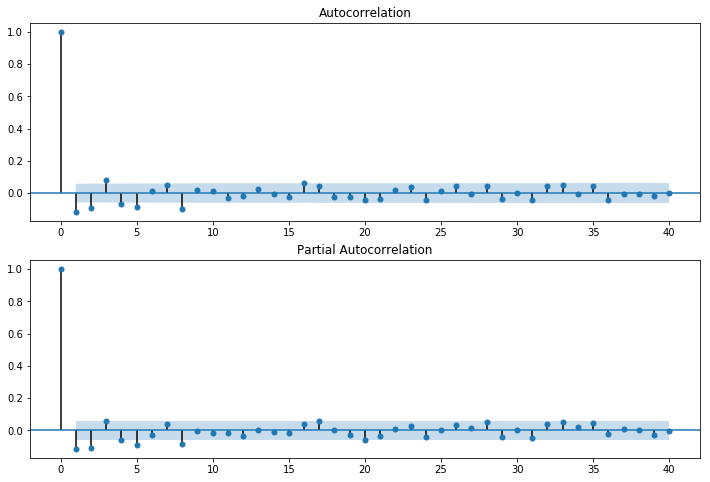

In [50]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['MSFT'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tech_stocks_ti['MSFT'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [51]:
msft_train_data, msft_test_data = tech_stocks_ti['MSFT'][0:int(len(tech_stocks_ti['MSFT'])*0.8)], tech_stocks_ti['MSFT'][int(len(tech_stocks_ti['MSFT'])*0.8):]

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  7.319764272038677
Root MSE:  9.552454944504783


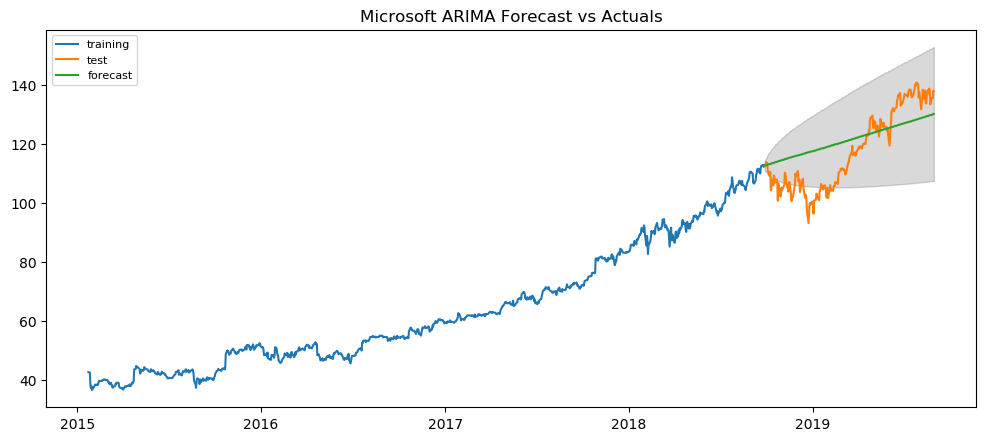

In [52]:
# fit model
model=sm.tsa.ARIMA(endog=msft_train_data, order=(2,1,1))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(len(msft_test_data), alpha=0.05)
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc, index=msft_test_data.index)
#print(fc_series)
lower_series = pd.Series(conf[:, 0], index=msft_test_data.index)
upper_series = pd.Series(conf[:, 1], index=msft_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(msft_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(msft_test_data, fc_series)))
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(msft_train_data, label='training')
plt.plot(msft_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Microsoft ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
msft_model=sm.tsa.ARIMA(endog=tech_stocks_ti['MSFT'],order=(2,1,1))
msft_results=msft_model.fit()
print(msft_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.MSFT   No. Observations:                 1159
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1818.309
Method:                       css-mle   S.D. of innovations              1.162
Date:                Wed, 18 Sep 2019   AIC                           3646.617
Time:                        12:55:48   BIC                           3671.894
Sample:                             1   HQIC                          3656.155
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0824      0.029      2.884      0.004       0.026       0.138
ar.L1.D.MSFT    -0.5903      0.204     -2.893      0.004      -0.990      -0.190
ar.L2.D.MSFT    -0.1653      0.031     -5.40

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Decompositional Trend

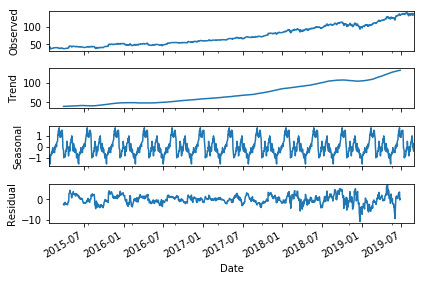

<Figure size 1296x864 with 0 Axes>

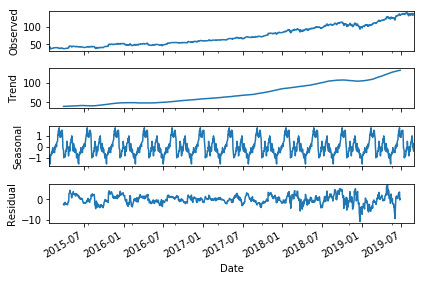

In [54]:
msft_decompose_df = tech_stocks_ti['MSFT'].reset_index()
msft_decompose_df['Date'] = pd.to_datetime(msft_decompose_df['Date'])
msft_decompose_df = msft_decompose_df.set_index('Date')
result = seasonal_decompose(msft_decompose_df['MSFT'], model="additive",freq=90)
fig = plt.figure(figsize=(18,12))
result.plot()

In [55]:
msft_trend = result.trend.dropna()
msft_resid = result.resid.dropna()

Text(0, 0.5, 'Adjusted Closing Price')

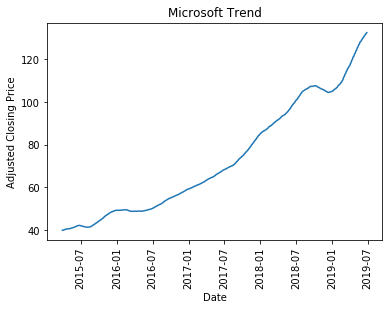

In [56]:
plt.plot(msft_trend)
plt.title('Microsoft Trend')
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  2.001334807214131
Root MSE:  3.4794612934253117


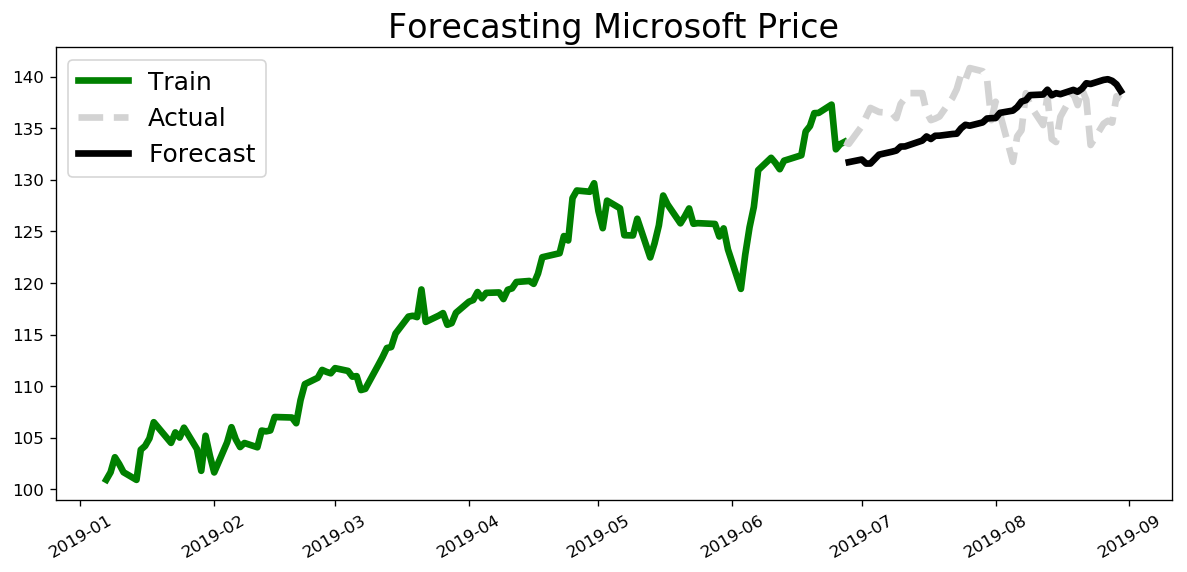

In [66]:
# fit model
model=sm.tsa.ARIMA(endog=msft_trend, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(45, alpha=0.05)

#print(np.array(fc)+np.array(result.seasonal)[:30])

predictions = fc + result.seasonal.iloc[:45]
predictions = predictions.reset_index()
predictions = predictions.drop('Date', axis=1)

predictions['Date'] = tech_stocks_ti['MSFT'][-45:].index
predictions = predictions.set_index(['Date'])
#predictions

plt.figure(figsize=(12,5), dpi=120)
plt.plot(tech_stocks_ti['MSFT'][-165:-45], label='Train', color="green", linewidth="4")
plt.plot(tech_stocks_ti['MSFT'][-46:], label='Actual', color="lightgrey", linewidth="4", linestyle="dashed")
plt.plot(predictions, label='Forecast', color="black", linewidth="4")
#plt.plot(tech_stocks_ti['MSFT'][-165:-45][-1], tech_stocks_ti['MSFT'][-45:][0], color="blue")
plt.title('Forecasting Microsoft Price', fontsize=20)
#plt.xlabel('Date', fontsize=12)
#plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=30)
plt.legend(loc='upper left', fontsize=15)
#ax.tick_params(axis="x", labelsize=8)
#ax.tick_params(axis="y", labelsize=20)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(tech_stocks_ti['MSFT'][-45:], predictions))
print("Root MSE: ", np.sqrt(mean_squared_error(tech_stocks_ti['MSFT'][-45:], predictions)))

### SARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Absolute Percentage Error:  8.038507166855592
Root MSE:  10.438081487675118


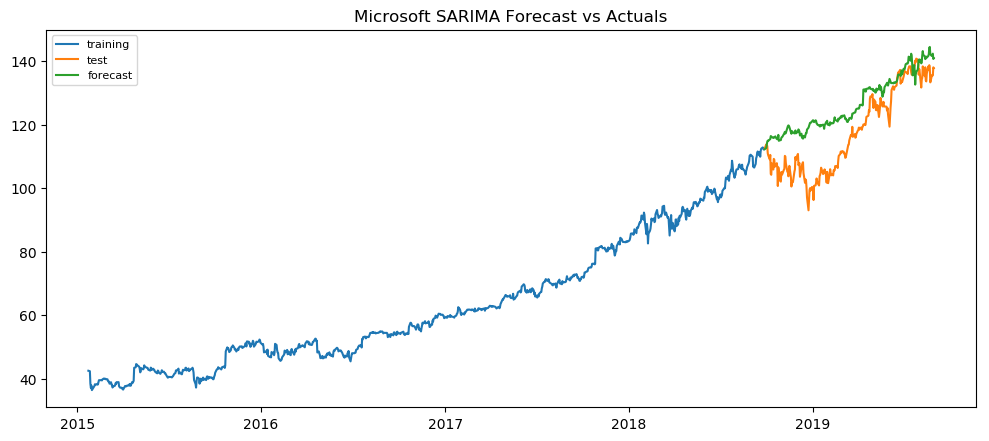

In [58]:
# fit model
model=sm.tsa.statespace.SARIMAX(endog=msft_train_data, order=(2,1,1), seasonal_order=(0,1,0,365), enforce_stationarity=False, enforce_invertibility=False, alpha=0.05)
model_fit = model.fit(disp=False)
# make prediction


fc = model_fit.forecast(len(msft_test_data))

#fc = model_fit.get_prediction(len(amzn_test_data), dynamic=False).predicted_mean
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc.values, index=msft_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(msft_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(msft_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(msft_train_data, label='training')
plt.plot(msft_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Microsoft SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

## FB

### ARIMA

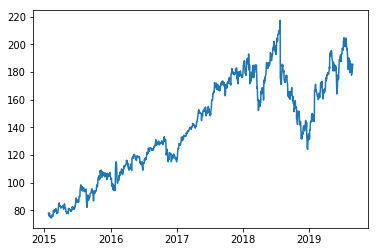

In [59]:
plt.plot(tech_stocks_ti['FB'])

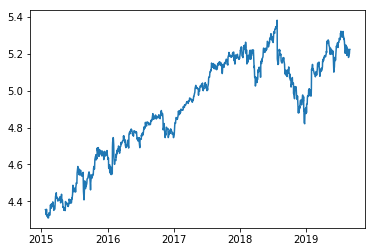

In [60]:
plt.plot(np.log(tech_stocks_ti['FB']))

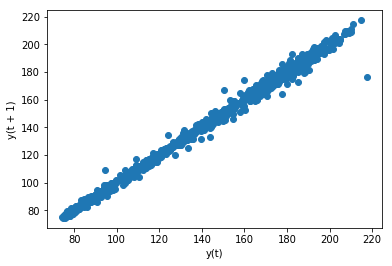

In [61]:
lag_plot(tech_stocks_ti['FB'])

In [62]:
result = adfuller(tech_stocks_ti['FB'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.542849
p-value: 0.512218


In [63]:
result = adfuller(tech_stocks_ti['AMZN'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.932393
p-value: 0.000000


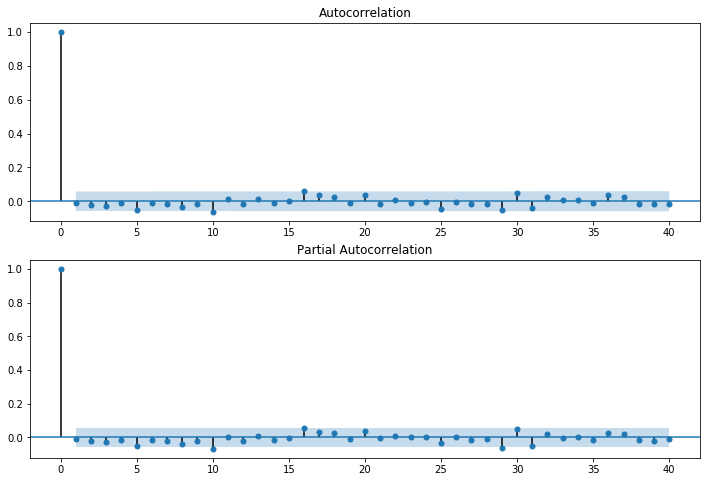

In [64]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['FB'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tech_stocks_ti['FB'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [65]:
fb_train_data, fb_test_data = tech_stocks_ti['FB'][0:int(len(tech_stocks_ti['FB'])*0.8)], tech_stocks_ti['FB'][int(len(tech_stocks_ti['FB'])*0.8):]

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  10.157616157526817
Root MSE:  19.429927115330905


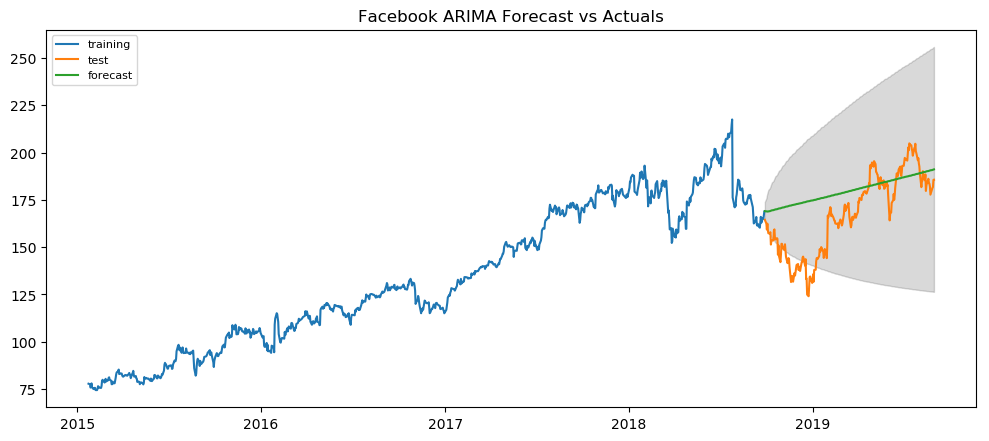

In [66]:
# fit model
model=sm.tsa.ARIMA(endog=fb_train_data, order=(5,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(len(fb_test_data), alpha=0.05)
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc, index=fb_test_data.index)
#print(fc_series)
lower_series = pd.Series(conf[:, 0], index=fb_test_data.index)
upper_series = pd.Series(conf[:, 1], index=fb_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(fb_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(fb_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fb_train_data, label='training')
plt.plot(fb_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Facebook ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [67]:
fb_model=sm.tsa.ARIMA(endog=tech_stocks_ti['FB'],order=(5,1,0))
fb_results=fb_model.fit()
print(fb_results.summary())

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.FB   No. Observations:                 1159
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2802.372
Method:                       css-mle   S.D. of innovations              2.716
Date:                Wed, 11 Sep 2019   AIC                           5618.743
Time:                        12:34:04   BIC                           5654.131
Sample:                             1   HQIC                          5632.096
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0927      0.071      1.309      0.191      -0.046       0.232
ar.L1.D.FB    -0.0113      0.029     -0.384      0.701      -0.069       0.046
ar.L2.D.FB    -0.0225      0.029     -0.767      0.4

In [68]:
fb_df = TiingoDailyReader('FB', start=start, end=end, api_key=api_token).read().reset_index()
fb_df

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
0,FB,2019-09-03 00:00:00+00:00,182.39,185.6700,182.1100,184.00,9792187,182.39,0.0,185.6700,182.1100,184.00,1.0,9792187
1,FB,2019-09-04 00:00:00+00:00,187.14,187.7494,183.8900,184.65,11314571,187.14,0.0,187.7494,183.8900,184.65,1.0,11314571
2,FB,2019-09-05 00:00:00+00:00,190.90,191.3600,187.9400,188.53,13896621,190.90,0.0,191.3600,187.9400,188.53,1.0,13896621
3,FB,2019-09-06 00:00:00+00:00,187.49,190.2100,186.3500,190.21,15226820,187.49,0.0,190.2100,186.3500,190.21,1.0,15226820
4,FB,2019-09-09 00:00:00+00:00,188.76,188.9800,185.8466,187.73,14722402,188.76,0.0,188.9800,185.8466,187.73,1.0,14722402
5,FB,2019-09-10 00:00:00+00:00,186.17,188.1000,184.5500,187.44,15455867,186.17,0.0,188.1000,184.5500,187.44,1.0,15455867


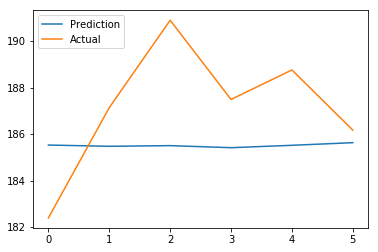

In [69]:
fb_forecast,std,conf=fb_results.forecast(6)
plt.plot(fb_forecast, label='Prediction')
plt.plot(fb_df['adjClose'], label='Actual')
plt.legend(loc='upper left')

In [70]:
mean_absolute_percentage_error(fb_df['adjClose'], fb_forecast)

1.4258763213161294

###  Decompositional Trend

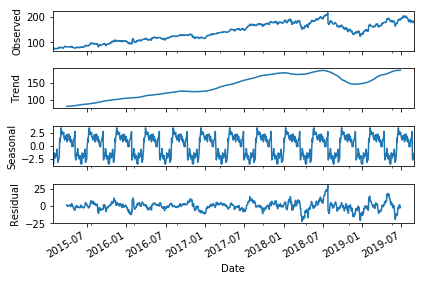

<Figure size 1296x864 with 0 Axes>

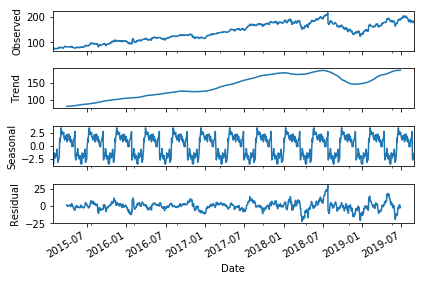

In [71]:
fb_decompose_df = tech_stocks_ti['FB'].reset_index()
fb_decompose_df['Date'] = pd.to_datetime(fb_decompose_df['Date'])
fb_decompose_df = fb_decompose_df.set_index('Date')
result = seasonal_decompose(fb_decompose_df['FB'], freq=90)
fig = plt.figure(figsize=(18,12))
result.plot()

In [72]:
fb_trend = result.trend.dropna()
fb_resid = result.resid.dropna()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  4.048123339723377
Root MSE:  11.022727055270728


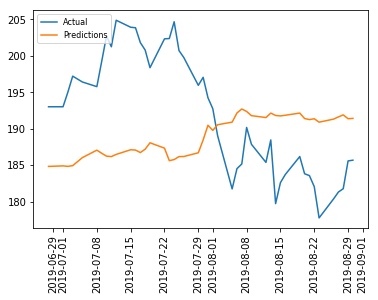

In [73]:
# fit model
model=sm.tsa.ARIMA(endog=fb_trend, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(45, alpha=0.05)

#print(np.array(fc)+np.array(result.seasonal)[:30])

predictions = fc + result.seasonal.iloc[:45]
predictions = predictions.reset_index()
predictions = predictions.drop('Date', axis=1)

predictions['Date'] = tech_stocks_ti['FB'][-45:].index
predictions = predictions.set_index(['Date'])
#predictions
plt.plot(tech_stocks_ti['FB'][-45:], label='Actual')
plt.plot(predictions, label='Predictions')
plt.xticks(rotation='vertical')
plt.legend(loc='upper left', fontsize=8)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(tech_stocks_ti['FB'][-45:], predictions))
print("Root MSE: ", np.sqrt(mean_squared_error(tech_stocks_ti['FB'][-45:], predictions)))

### SARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Absolute Percentage Error:  18.304901570491275
Root MSE:  31.644179724552313


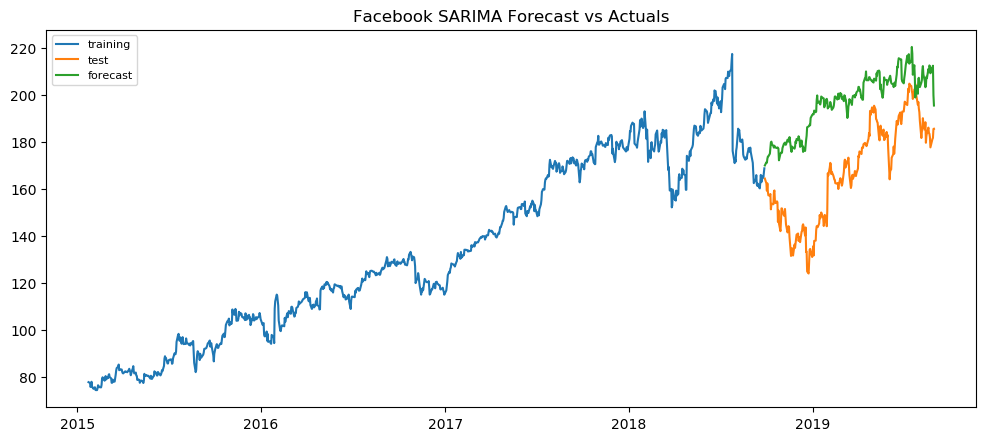

In [74]:
# fit model
model=sm.tsa.statespace.SARIMAX(endog=fb_train_data, order=(5,1,0), seasonal_order=(0,1,0,365), enforce_stationarity=False, enforce_invertibility=False, alpha=0.05)
model_fit = model.fit(disp=False)
# make prediction


fc = model_fit.forecast(len(fb_test_data))

#fc = model_fit.get_prediction(len(amzn_test_data), dynamic=False).predicted_mean
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc.values, index=fb_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(fb_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(fb_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fb_train_data, label='training')
plt.plot(fb_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Facebook SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## GOOGL

### ARIMA

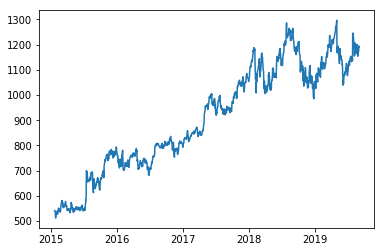

In [75]:
plt.plot(tech_stocks_ti['GOOGL'])

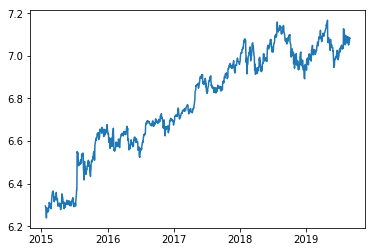

In [76]:
plt.plot(np.log(tech_stocks_ti['GOOGL']))

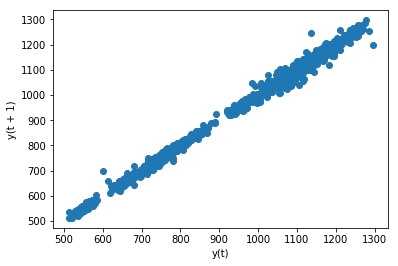

In [77]:
lag_plot(tech_stocks_ti['GOOGL'])

In [78]:
result = adfuller(tech_stocks_ti['GOOGL'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.301088
p-value: 0.628675


In [79]:
result = adfuller(tech_stocks_ti['GOOGL'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.650123
p-value: 0.000000


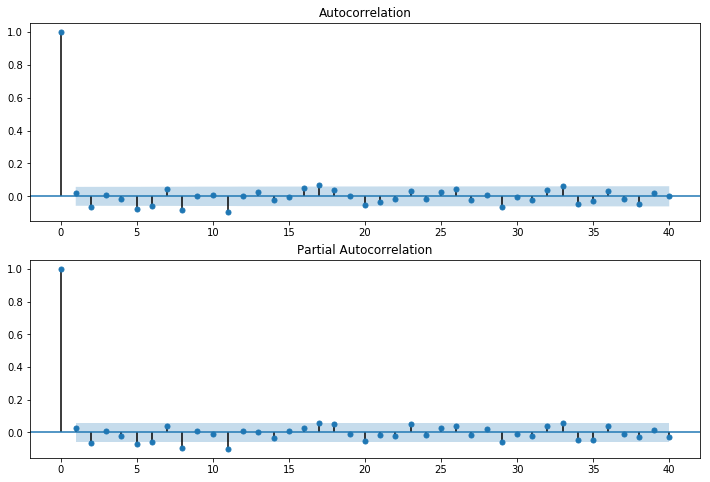

In [80]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['GOOGL'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tech_stocks_ti['GOOGL'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [81]:
googl_train_data, googl_test_data = tech_stocks_ti['GOOGL'][0:int(len(tech_stocks_ti['GOOGL'])*0.8)], tech_stocks_ti['GOOGL'][int(len(tech_stocks_ti['GOOGL'])*0.8):]

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  14.412135172539637
Root MSE:  170.70133564728008


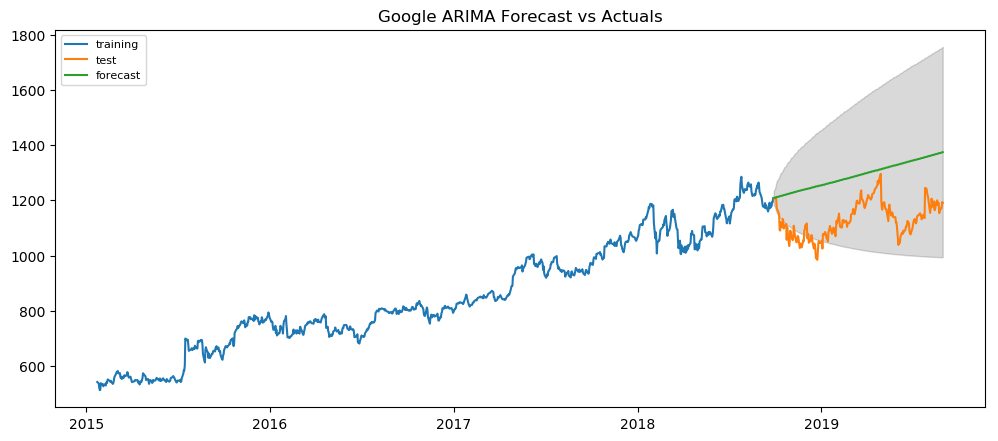

In [82]:
# fit model
model=sm.tsa.ARIMA(endog=googl_train_data, order=(2,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(len(googl_test_data), alpha=0.05)
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc, index=googl_test_data.index)
#print(fc_series)
lower_series = pd.Series(conf[:, 0], index=googl_test_data.index)
upper_series = pd.Series(conf[:, 1], index=googl_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(googl_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(googl_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(googl_train_data, label='training')
plt.plot(googl_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Google ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [83]:
googl_model=sm.tsa.ARIMA(endog=tech_stocks_ti['GOOGL'],order=(2,1,0))
googl_results=googl_model.fit()
print(googl_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.GOOGL   No. Observations:                 1159
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4718.151
Method:                       css-mle   S.D. of innovations             14.181
Date:                Wed, 11 Sep 2019   AIC                           9444.302
Time:                        12:36:02   BIC                           9464.524
Sample:                             1   HQIC                          9451.933
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5597      0.399      1.402      0.161      -0.223       1.342
ar.L1.D.GOOGL     0.0245      0.029      0.835      0.404      -0.033       0.082
ar.L2.D.GOOGL    -0.0682      0.029     

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [84]:
googl_df = TiingoDailyReader('GOOGL', start=start, end=end, api_key=api_token).read().reset_index()
googl_df

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
0,GOOGL,2019-09-03 00:00:00+00:00,1169.55,1189.08,1163.71,1181.85,1296116,1169.55,0.0,1189.08,1163.71,1181.85,1.0,1296116
1,GOOGL,2019-09-04 00:00:00+00:00,1182.27,1184.88,1171.53,1179.45,1065666,1182.27,0.0,1184.88,1171.53,1179.45,1.0,1065666
2,GOOGL,2019-09-05 00:00:00+00:00,1212.19,1214.00,1192.69,1193.66,1320656,1212.19,0.0,1214.00,1192.69,1193.66,1.0,1320656
3,GOOGL,2019-09-06 00:00:00+00:00,1206.32,1212.94,1203.26,1209.14,948580,1206.32,0.0,1212.94,1203.26,1209.14,1.0,948580
4,GOOGL,2019-09-09 00:00:00+00:00,1205.27,1220.55,1193.17,1207.08,1592958,1205.27,0.0,1220.55,1193.17,1207.08,1.0,1592958
5,GOOGL,2019-09-10 00:00:00+00:00,1205.70,1210.00,1196.01,1196.09,1396077,1205.70,0.0,1210.00,1196.01,1196.09,1.0,1396077


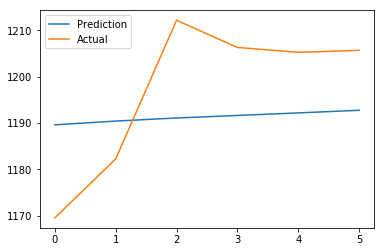

In [85]:
googl_forecast,std,conf=googl_results.forecast(6)
plt.plot(googl_forecast, label='Prediction')
plt.plot(googl_df['adjClose'], label='Actual')
plt.legend(loc='upper left')

In [86]:
mean_absolute_percentage_error(googl_df['adjClose'], googl_forecast)

1.253303494683455

### Decompositional Trend

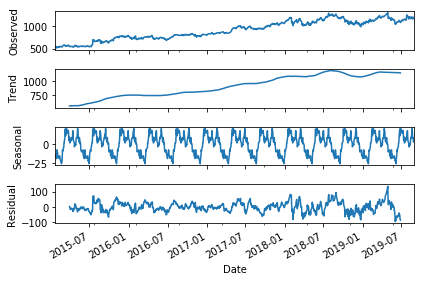

<Figure size 1296x864 with 0 Axes>

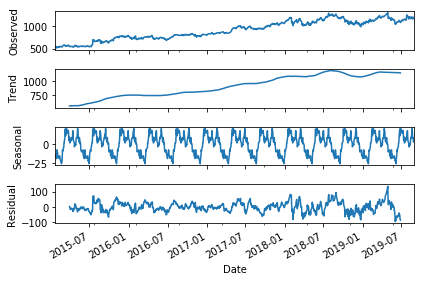

In [87]:
googl_decompose_df = tech_stocks_ti['GOOGL'].reset_index()
googl_decompose_df['Date'] = pd.to_datetime(googl_decompose_df['Date'])
googl_decompose_df = googl_decompose_df.set_index('Date')
result = seasonal_decompose(googl_decompose_df['GOOGL'], freq=90)
fig = plt.figure(figsize=(18,12))
result.plot()

In [88]:
googl_trend = result.trend.dropna()
googl_resid = result.resid.dropna()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  3.3664284487815874
Root MSE:  48.975450676977886


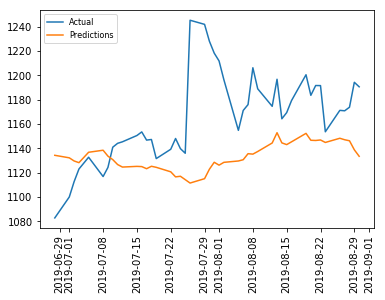

In [89]:
# fit model
model=sm.tsa.ARIMA(endog=googl_trend, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(45, alpha=0.05)

#print(np.array(fc)+np.array(result.seasonal)[:30])

predictions = fc + result.seasonal.iloc[:45]
predictions = predictions.reset_index()
predictions = predictions.drop('Date', axis=1)

predictions['Date'] = tech_stocks_ti['GOOGL'][-45:].index
predictions = predictions.set_index(['Date'])
#predictions
plt.plot(tech_stocks_ti['GOOGL'][-45:], label='Actual')
plt.plot(predictions, label='Predictions')
plt.xticks(rotation='vertical')
plt.legend(loc='upper left', fontsize=8)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(tech_stocks_ti['GOOGL'][-45:], predictions))
print("Root MSE: ", np.sqrt(mean_squared_error(tech_stocks_ti['GOOGL'][-45:], predictions)))

### SARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Absolute Percentage Error:  21.05770713841851
Root MSE:  249.86947807300533


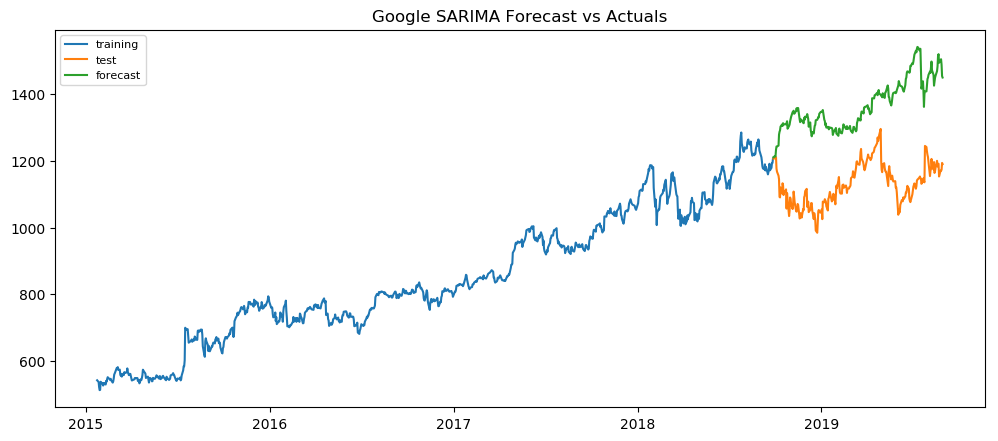

In [90]:
# fit model
model=sm.tsa.statespace.SARIMAX(endog=googl_train_data, order=(2,1,0), seasonal_order=(0,1,0,365), enforce_stationarity=False, enforce_invertibility=False, alpha=0.05)
model_fit = model.fit(disp=False)
# make prediction


fc = model_fit.forecast(len(googl_test_data))

#fc = model_fit.get_prediction(len(amzn_test_data), dynamic=False).predicted_mean
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc.values, index=googl_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(googl_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(googl_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(googl_train_data, label='training')
plt.plot(googl_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Google SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## AAPL

### ARIMA

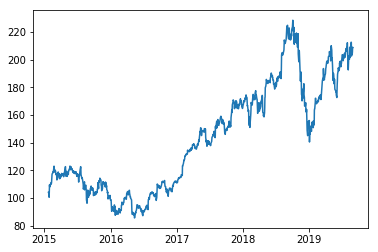

In [38]:
plt.plot(tech_stocks_ti['AAPL'])

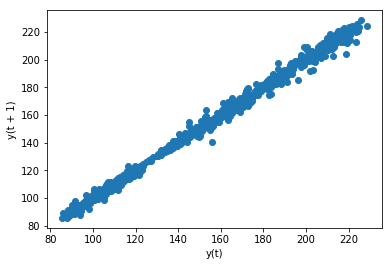

In [39]:
lag_plot(tech_stocks_ti['AAPL'])

In [40]:
result = adfuller(tech_stocks_ti['AAPL'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.634827
p-value: 0.862917


In [41]:
result = adfuller(tech_stocks_ti['AAPL'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.421799
p-value: 0.000000


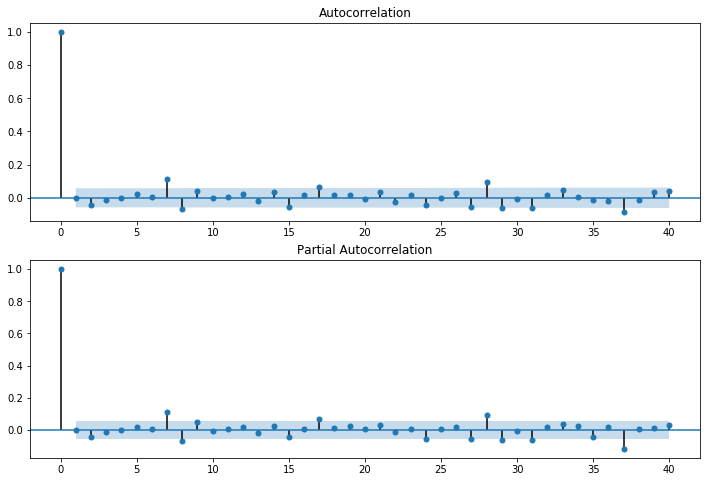

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tech_stocks_ti['AAPL'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tech_stocks_ti['AAPL'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [43]:
aapl_train_data, aapl_test_data = tech_stocks_ti['AAPL'][0:int(len(tech_stocks_ti['AAPL'])*0.8)], tech_stocks_ti['AAPL'][int(len(tech_stocks_ti['AAPL'])*0.8):]

Mean Absolute Percentage Error:  26.920031256228015
Root MSE:  52.021138682924246


/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


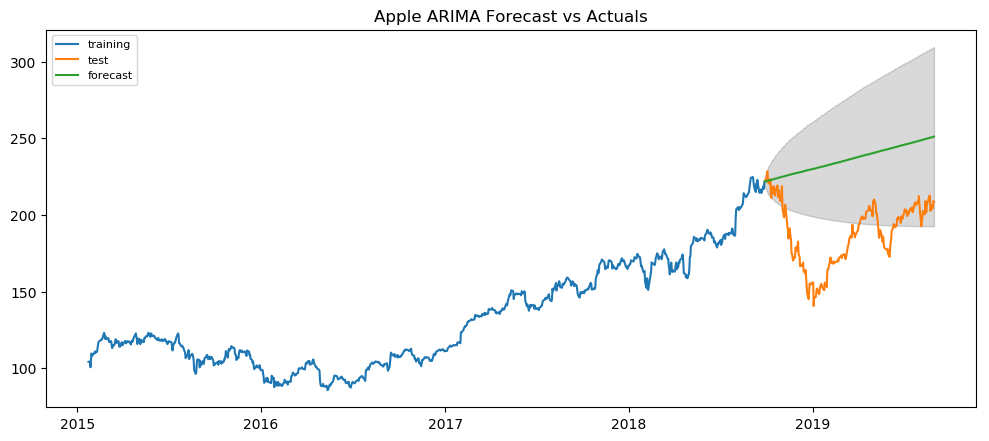

In [44]:
# fit model
model=sm.tsa.ARIMA(endog=aapl_train_data, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(len(aapl_test_data), alpha=0.05)
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc, index=aapl_test_data.index)
#print(fc_series)
lower_series = pd.Series(conf[:, 0], index=aapl_test_data.index)
upper_series = pd.Series(conf[:, 1], index=aapl_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(aapl_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(aapl_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(aapl_train_data, label='training')
plt.plot(aapl_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Apple ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
aapl_model=sm.tsa.ARIMA(endog=tech_stocks_ti['AAPL'],order=(1,1,0))
aapl_results=aapl_model.fit()
print(aapl_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.AAPL   No. Observations:                 1159
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2652.144
Method:                       css-mle   S.D. of innovations              2.385
Date:                Fri, 13 Sep 2019   AIC                           5310.287
Time:                        15:58:59   BIC                           5325.453
Sample:                             1   HQIC                          5316.010
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0903      0.070      1.292      0.196      -0.047       0.227
ar.L1.D.AAPL    -0.0031      0.029     -0.104      0.917      -0.061       0.054
                                    Roots   

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [46]:
aapl_df = TiingoDailyReader('AAPL', start=start, end=end, api_key=api_token).read().reset_index()
aapl_df

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
0,AAPL,2019-09-03 00:00:00+00:00,205.700,206.98,204.22,206.43,20059574,205.700,0.0,206.98,204.22,206.43,1.0,20059574
1,AAPL,2019-09-04 00:00:00+00:00,209.190,209.48,207.32,208.39,19216820,209.190,0.0,209.48,207.32,208.39,1.0,19216820
2,AAPL,2019-09-05 00:00:00+00:00,213.280,213.97,211.51,212.00,23946984,213.280,0.0,213.97,211.51,212.00,1.0,23946984
3,AAPL,2019-09-06 00:00:00+00:00,213.260,214.42,212.51,214.05,19362294,213.260,0.0,214.42,212.51,214.05,1.0,19362294
4,AAPL,2019-09-09 00:00:00+00:00,214.170,216.44,211.07,214.84,27309401,214.170,0.0,216.44,211.07,214.84,1.0,27309401
5,AAPL,2019-09-10 00:00:00+00:00,216.700,216.78,211.71,213.86,31777931,216.700,0.0,216.78,211.71,213.86,1.0,31777931
6,AAPL,2019-09-11 00:00:00+00:00,223.590,223.71,217.73,218.07,44289646,223.590,0.0,223.71,217.73,218.07,1.0,44289646
7,AAPL,2019-09-12 00:00:00+00:00,223.085,226.42,222.86,224.80,32226669,223.085,0.0,226.42,222.86,224.80,1.0,32226669
8,AAPL,2019-09-13 00:00:00+00:00,218.750,220.79,217.02,220.00,39143759,218.750,0.0,220.79,217.02,220.00,1.0,39143759


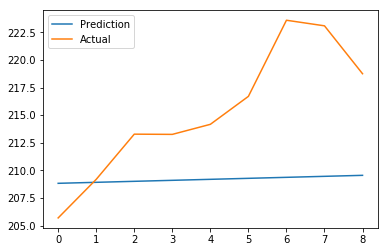

In [49]:
aapl_forecast,std,conf=aapl_results.forecast(9)
plt.plot(aapl_forecast, label='Prediction')
plt.plot(aapl_df['adjClose'], label='Actual')
plt.legend(loc='upper left')

In [50]:
mean_absolute_percentage_error(aapl_df['adjClose'], aapl_forecast)

3.1129877185498556

### Decompositional Trend

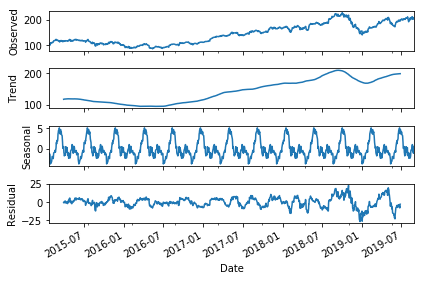

<Figure size 1296x864 with 0 Axes>

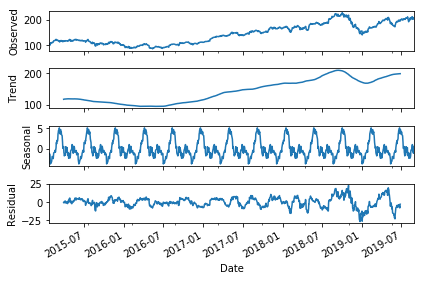

In [51]:
aapl_decompose_df = tech_stocks_ti['AAPL'].reset_index()
aapl_decompose_df['Date'] = pd.to_datetime(aapl_decompose_df['Date'])
aapl_decompose_df = aapl_decompose_df.set_index('Date')
result = seasonal_decompose(aapl_decompose_df['AAPL'], freq=90)
fig = plt.figure(figsize=(18,12))
result.plot()

In [52]:
aapl_trend = result.trend.dropna()
aapl_resid = result.resid.dropna()

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean Absolute Percentage Error:  2.7938393942722515
Root MSE:  6.5265910537990255


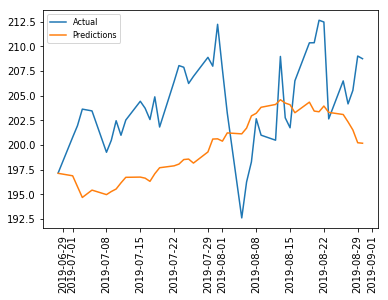

In [53]:
# fit model
model=sm.tsa.ARIMA(endog=aapl_trend, order=(1,1,0))
model_fit = model.fit(disp=False)
# make prediction

fc, se, conf = model_fit.forecast(45, alpha=0.05)

#print(np.array(fc)+np.array(result.seasonal)[:30])

predictions = fc + result.seasonal.iloc[:45]
predictions = predictions.reset_index()
predictions = predictions.drop('Date', axis=1)

predictions['Date'] = tech_stocks_ti['AAPL'][-45:].index
predictions = predictions.set_index(['Date'])
#predictions
plt.plot(tech_stocks_ti['AAPL'][-45:], label='Actual')
plt.plot(predictions, label='Predictions')
plt.xticks(rotation='vertical')
plt.legend(loc='upper left', fontsize=8)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(tech_stocks_ti['AAPL'][-45:], predictions))
print("Root MSE: ", np.sqrt(mean_squared_error(tech_stocks_ti['AAPL'][-45:], predictions)))

### SARIMA

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Absolute Percentage Error:  29.904413204402463
Root MSE:  57.37544626897002


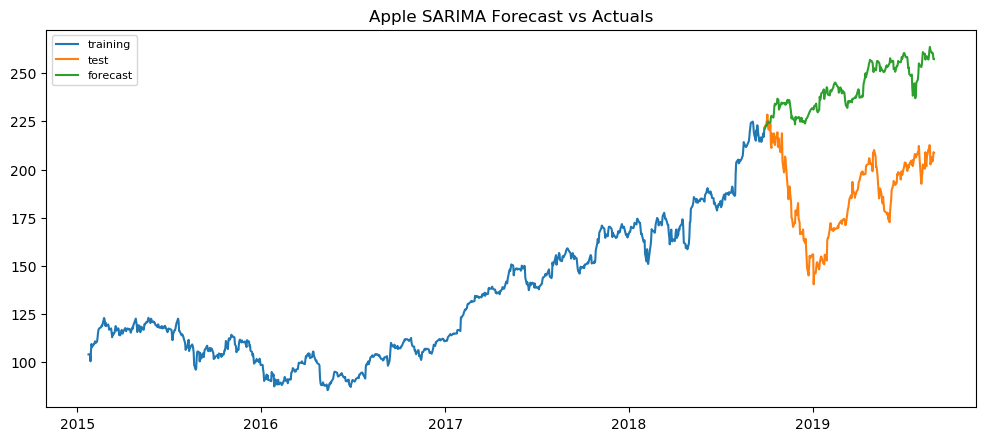

In [105]:
# fit model
model=sm.tsa.statespace.SARIMAX(endog=aapl_train_data, order=(1,1,0), seasonal_order=(0,1,0,365), enforce_stationarity=False, enforce_invertibility=False, alpha=0.05)
model_fit = model.fit(disp=False)
# make prediction


fc = model_fit.forecast(len(aapl_test_data))

#fc = model_fit.get_prediction(len(amzn_test_data), dynamic=False).predicted_mean
#fc = model_fit.predict(amzn_test_data)
# Make as pandas series
fc_series = pd.Series(fc.values, index=googl_test_data.index)

print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(aapl_test_data, fc_series))
print("Root MSE: ", np.sqrt(mean_squared_error(aapl_test_data, fc_series)))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(aapl_train_data, label='training')
plt.plot(aapl_test_data, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Apple SARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()